# Experiments 1 & 2
Testing ICP using the SVD approach and the Gauss Newton nonlinear least-squares approach

In [37]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

### Functions for visualizing the data
Sourced from  Costas Andreou: https://towardsdatascience.com/learn-how-to-create-animated-graphs-in-python-fce780421afe

In [38]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

### Generate Example Data

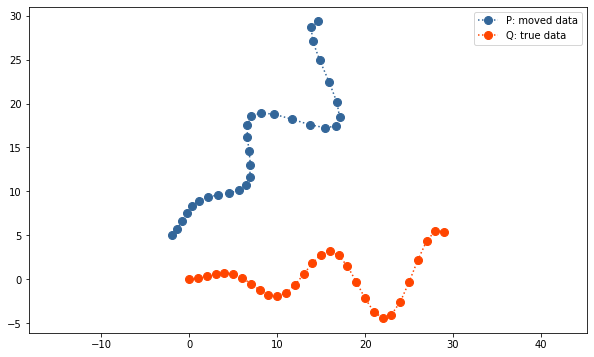

In [39]:
# initialize perturbation rotation
angle = pi / 4
R_true = np.array([[cos(angle), -sin(angle)], 
                   [sin(angle),  cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
true_data = np.zeros((2, num_points))
true_data[0, :] = range(0, num_points)
true_data[1, :] = 0.2 * true_data[0, :] * np.sin(0.5 * true_data[0, :]) 
# Move the data
moved_data = R_true.dot(true_data) + t_true

# Assign to variables we use in formulas.
Q = true_data
P = moved_data

plot_data(moved_data, true_data, "P: moved data", "Q: true data")
plt.show()

### Correspondences computation

In [40]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

# ICP based on SVD

### Make data centered

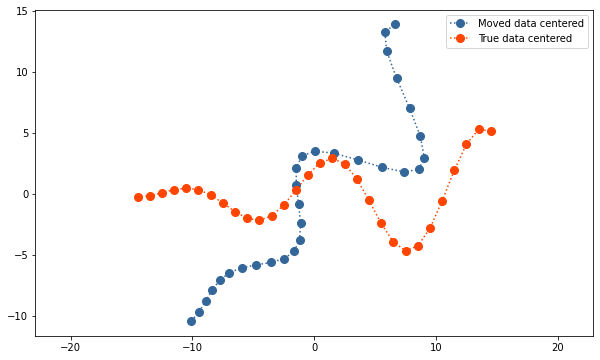

In [41]:
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.array([reduced_data.mean(axis=1)]).T
    return center, data - center

center_of_P, P_centered = center_data(P)
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()

### Compute and show Correspondences

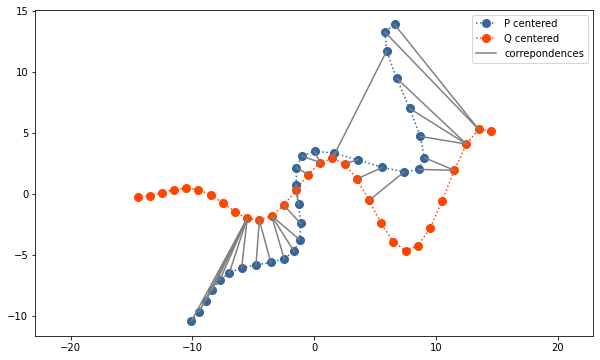

In [42]:
correspondences = get_correspondence_indices(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

### Compute cross covariance

In [43]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((2, 2))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

[[1113.97274605 1153.71870122]
 [ 367.39948556  478.81890396]]


### Find R and t from SVD decomposition

In [44]:
U, S, V_T = np.linalg.svd(cov)
print(S)
R_found = U.dot(V_T)
t_found = center_of_Q - R_found.dot(center_of_P)
print("R_found =\n", R_found)
print("t_found =\n", t_found)

[1712.35558954   63.95608054]
R_found =
 [[ 0.89668479  0.44266962]
 [-0.44266962  0.89668479]]
t_found =
 [[  0.4278782 ]
 [-10.01055887]]


### Apply a single correction to P and visualize the result

[[  0.4278782 ]
 [-10.01055887]]
[[ 0.89668479  0.44266962]
 [-0.44266962  0.89668479]]


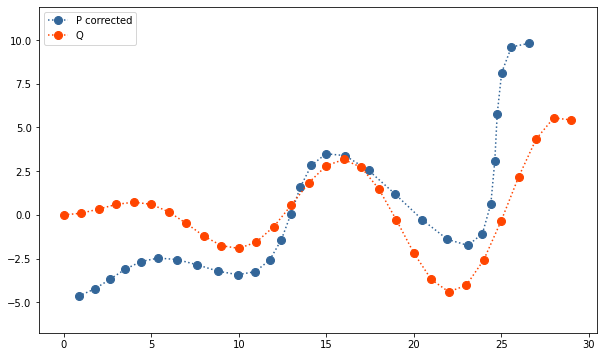

Squared diff: (P_corrected - Q) =  16.052894296516946


In [45]:
print(t_found)
print(R_found)
P_corrected = R_found.dot(P) + t_found
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q')
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

### Making the process Iterative

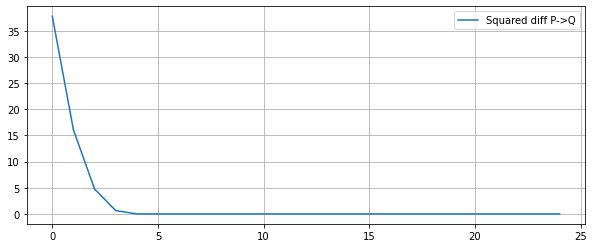

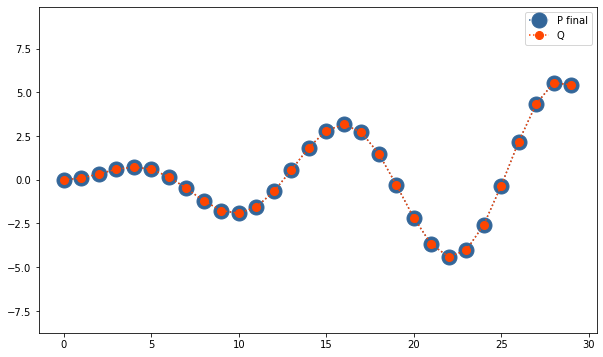

[37.76096161797431, 16.05289429651695, 4.747691495229582, 0.6307436032154953, 1.9152594123818474e-14, 3.0516305576028696e-14, 2.3045035070939353e-14, 2.240686492382184e-14, 2.1384135484410843e-14, 2.2231471055791033e-14, 2.1983624904025976e-14, 2.276847235768553e-14, 3.3779846875592266e-14, 3.95725405266443e-14, 4.873753417699702e-14, 5.4639534794395146e-14, 3.924777756327186e-14, 4.474300374870343e-14, 5.043744086753246e-14, 5.1403415960937423e-14, 5.3121097354072054e-14, 5.54037859806299e-14, 4.383024603653258e-14, 4.904291616414862e-14, 5.4684267242623873e-14]


In [54]:
def icp_svd(P, Q, iterations=25, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in range(iterations):
        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)
        correspondences = get_correspondence_indices(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)  
        t = center_of_Q - R.dot(center_of_P)  
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

P_values, norm_values, corresp_values = icp_svd(P, Q)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

In [47]:
animate_results(P_values, Q, corresp_values, xlim=(-5, 35), ylim=(-5, 35))

# Non-linear Least-squares based ICP

### Correspondeces

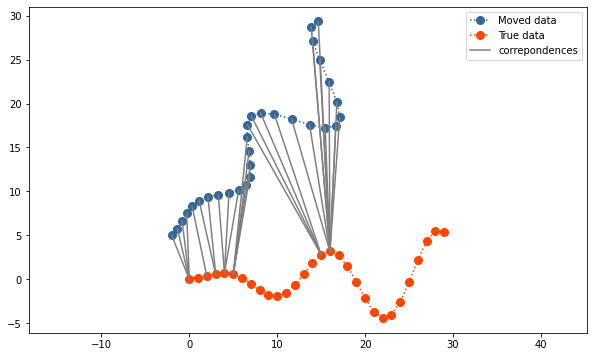

In [48]:
correspondences = get_correspondence_indices(P, Q)
ax = plot_data(P, Q, "Moved data", "True data")
draw_correspondeces(P, Q, correspondences, ax)
plt.show()

### Jacobian

In [49]:
def dR(theta):
    return np.array([[-sin(theta), -cos(theta)],
                     [cos(theta),  -sin(theta)]])

def R(theta):
    return np.array([[cos(theta), -sin(theta)],
                     [sin(theta),  cos(theta)]])

In [50]:
def jacobian(x, p_point):
    theta = x[2]
    J = np.zeros((2, 3))
    J[0:2, 0:2] = np.identity(2)
    J[0:2, [2]] = dR(0).dot(p_point)
    return J

def error(x, p_point, q_point):
    rotation = R(x[2])
    translation = x[0:2]
    prediction = rotation.dot(p_point) + translation
    return prediction - q_point

### Solving the Least Squares problem

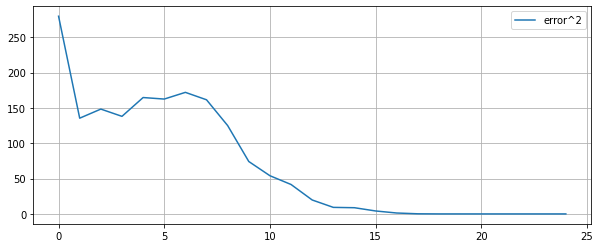

[279.8595127207586, 135.53670591984317, 148.41156916870506, 138.13600690872167, 164.7628216353994, 162.60937583974712, 172.09657147196543, 161.58393072081967, 125.0867656866019, 74.18795088775204, 54.0702266703227, 41.64904459515243, 19.714135179690025, 9.258599804821069, 8.772642882322362, 4.1720680989041545, 1.2769314893000951, 0.16280347501872897, 0.014198093772484516, 0.0012239475378547767, 0.00010514834808155826, 9.024084124553723e-06, 7.742391050148922e-07, 6.642160394488831e-08, 5.698132817883857e-09]


In [53]:
def prepare_system(x, P, Q, correspondences, kernel=lambda distance: 1.0):
    H = np.zeros((3, 3))
    g = np.zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        e = error(x, p_point, q_point)
        weight = kernel(e)
        J = jacobian(x, p_point)
        H += weight * J.T.dot(J)
        g += weight * J.T.dot(e)
        chi += e.T * e
    return H, g, chi

def icp_least_squares(P, Q, iterations=25, kernel=lambda distance: 1.0):
    x = np.zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    for i in range(iterations):
        rot = R(x[2])
        t = x[0:2]
        correspondences = get_correspondence_indices(P_copy, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system(x, P, Q, correspondences, kernel)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        chi_values.append(chi.item(0))
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_copy = rot.dot(P.copy()) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

P_values, chi_values, corresp_values = icp_least_squares(P, Q)
plot_values(chi_values, label="error^2")
print(chi_values)

### Animiate it

In [52]:
animate_results(P_values, Q, corresp_values, xlim=(-10, 35), ylim=(-10, 30))